<a href="https://colab.research.google.com/github/yy0750/Analyzing_Depression_Emotions/blob/main/Analyzing_Depression_Emotions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Analyzing Depression Emotions



# Module Import

In [1]:
!pip install konlpy
!pip install squarify #트리맵

In [11]:
#코랩 한글 폰트 꺠짐 방지 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from scipy.sparse import hstack
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
import squarify
from wordcloud import WordCloud

In [3]:
plt.rc('font', family='NanumBarunGothic')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Load

In [38]:
df=pd.read_csv("/content/drive/MyDrive/code/감정분석/data.csv")

df['감정_대분류'] = df['감정_대분류'].str.strip()
unique_emotions = df['감정_대분류'].unique()
df['사람문장'] = df['사람문장1'] + df['사람문장2']

print(df.shape)
print(df.isna().sum())
df[['연령', '감정_대분류', '사람문장']].head()

(46009, 8)
번호        0
연령        0
성별        0
감정_대분류    0
감정_소분류    0
사람문장1     0
사람문장2     0
사람문장      0
dtype: int64


,연령,감정_대분류,사람문장
0,청년,기쁨,아내가 드디어 출산하게 되어서 정말 신이 나.아 지금 정말 신이 나.
1,노년,불안,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.건강할 때 관...
2,청소년,당황,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워.아직 학기 초...
3,노년,기쁨,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야. 너무 행복해.퇴...
4,노년,기쁨,빚을 드디어 다 갚게 되어서 이제야 안도감이 들어.빚도 다 갚았으니 당분간은 아무 ...


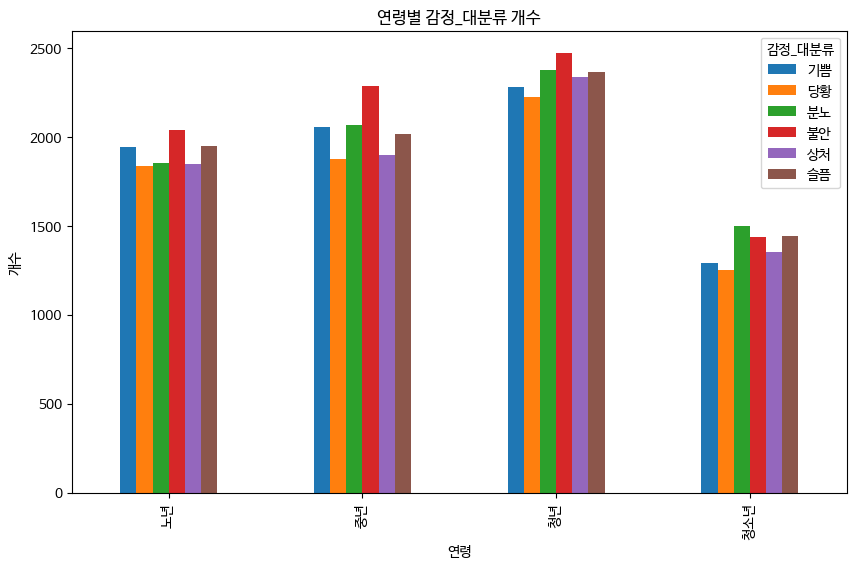

In [6]:
emotion_pivot = df.pivot_table(index='연령', columns='감정_대분류', aggfunc='size')

emotion_pivot.plot.bar(figsize=(10, 6))
plt.title('연령별 감정_대분류 개수')
plt.xlabel('연령')
plt.ylabel('개수')
plt.legend(title='감정_대분류')
plt.show()

- 데이터의 비율이 일정하고 라벨링도 되어있으므로 지도학습으로 접근한다.
- 분류 문제는 로지스틱 회귀나 SVM을 활용한다.
- 감성 분석에 자주 사용되는 것은 로지스틱 회귀이다.
- SVM은 학습에 많은 시간이 소요된다.

In [15]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def clean_text(text):
    text = re.sub(r'[^가-힣\s]', '', text)
    return text

okt = Okt()
def tokenize_text(text):
    return [word for word in okt.morphs(text) if word not in stopwords]

# 각 카테고리별 토큰화 및 빈도수 계산
category_words = {}
for category in df['감정_대분류'].unique():
    texts = df[df['감정_대분류'] == category]['사람문장'].apply(clean_text)
    tokens = texts.apply(tokenize_text)
    all_tokens = np.concatenate(tokens.values)
    word_freq = Counter(all_tokens)
    category_words[category] = word_freq

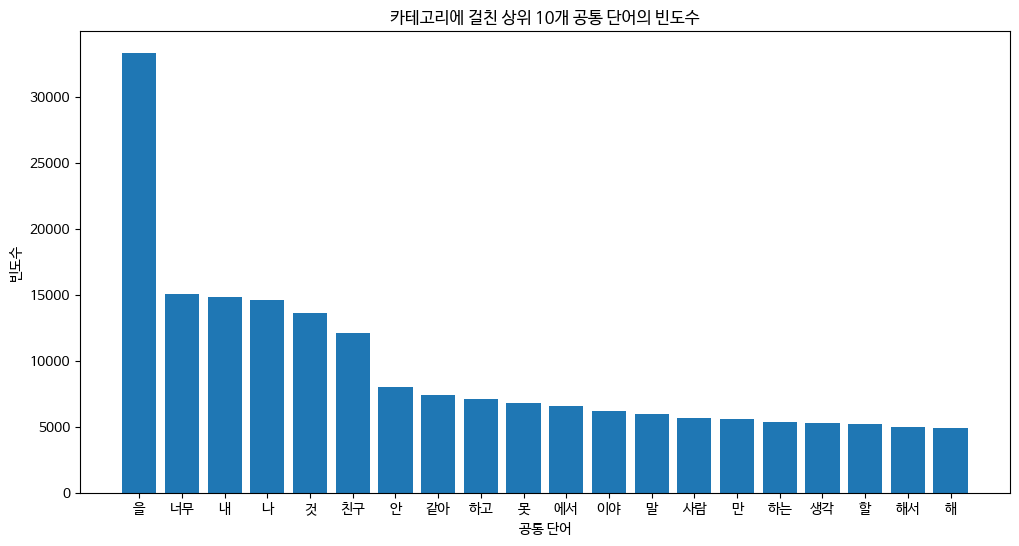

In [16]:
# 공통 단어 찾기
all_common_words = set.intersection(*[set(words.keys()) for words in category_words.values()])

common_word_freqs = {word: 0 for word in all_common_words}
for category in category_words:
    for word in all_common_words:
        common_word_freqs[word] += category_words[category].get(word, 0)


top_common_words_freqs = dict(Counter(common_word_freqs).most_common(20))
plt.figure(figsize=(12, 6))
plt.bar(top_common_words_freqs.keys(), top_common_words_freqs.values())
plt.xlabel('공통 단어')
plt.ylabel('빈도수')
plt.title('카테고리에 걸친 상위 10개 공통 단어의 빈도수')
plt.show()

In [39]:
top_common_words = set(word for word, freq in Counter(all_tokens).most_common(10))

def remove_top_common_words(tokens, top_common_words):
    return [token for token in tokens if token not in top_common_words]

df['최종_토큰화된_문장'] = df['토큰화된_문장'].apply(lambda tokens: remove_top_common_words(tokens, top_common_words))

In [18]:
# 벡터화를 위한 문자열로 변환
df['처리된_문장'] = df['최종_토큰화된_문장'].apply(lambda x: ' '.join(x))

# TF-IDF 벡터화
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['처리된_문장'])

# 연령 원-핫 인코딩
onehot_encoder = OneHotEncoder()
age_encoded = onehot_encoder.fit_transform(df[['연령']])


X = hstack([tfidf_matrix, age_encoded])
y = df['감정_대분류']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Model Learning and Optimizing

In [20]:
lr = LogisticRegression(random_state=0, max_iter=1000)
params = {'C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10]}
grid_cv = GridSearchCV(lr, param_grid=params, cv=3, scoring='accuracy', verbose=1)
grid_cv.fit(X_train, y_train)

Fitting 3 folds for each of 7 candidates, totalling 21 fits


GridSearchCV(cv=3, estimator=LogisticRegression(max_iter=1000, random_state=0),
             param_grid={'C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10]},
             scoring='accuracy', verbose=1)

In [36]:
print("Best Parameter: ", grid_cv.best_params_,"\n")

means = grid_cv.cv_results_['mean_test_score']
for mean, params in zip(means, grid_cv.cv_results_['params']):
    print("%0.3f for %r" % (mean, params))

Best Parameter:  {'C': 1} 

0.487 for {'C': 0.01}
0.566 for {'C': 0.03}
0.602 for {'C': 0.1}
0.624 for {'C': 0.3}
0.637 for {'C': 1}
0.637 for {'C': 3}
0.625 for {'C': 10}


## Performance

In [24]:
y_pred = grid_cv.best_estimator_.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.6574


## Precision, Recall, F1 Score

In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          기쁨       0.79      0.86      0.83      1526
          당황       0.65      0.59      0.62      1411
          분노       0.65      0.66      0.66      1538
          불안       0.60      0.65      0.62      1672
          상처       0.62      0.58      0.60      1484
          슬픔       0.63      0.60      0.61      1571

    accuracy                           0.66      9202
   macro avg       0.66      0.66      0.66      9202
weighted avg       0.66      0.66      0.66      9202



# 단어 빈도에 따른 시각화

##### 명사 추출

In [ ]:
def text_cleaning(text):
    hangul = re.compile('[^ ㄱ-ㅣ 가-힣]')
    result = hangul.sub('', text)
    okt = Okt()
    nouns = okt.nouns(result)
    nouns = [x for x in nouns if len(x) > 1]
    nouns = [x for x in nouns if x not in stopwords]
    return nouns


df['cleaned_nouns'] = df['사람문장'].apply(text_cleaning)

all_nouns = sum(df['cleaned_nouns'], [])

word_count = Counter(all_nouns)

##### 바 그래프

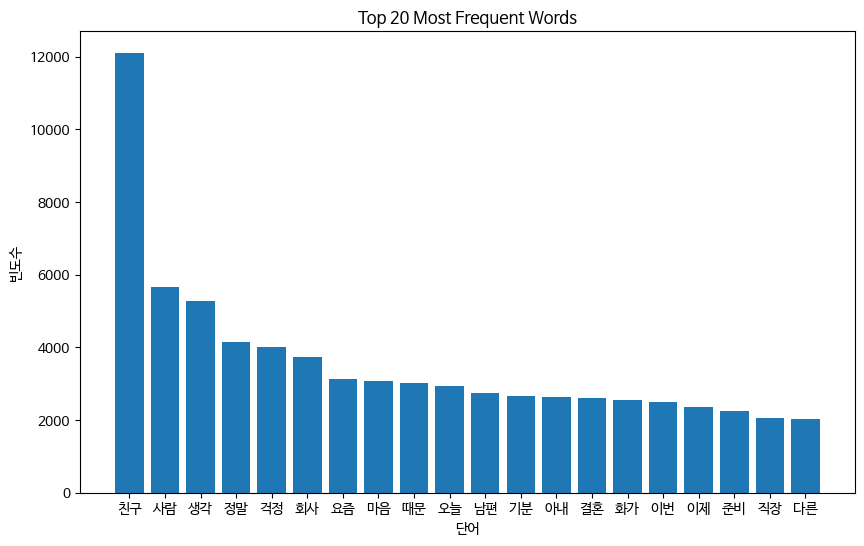

In [ ]:
top_n = 20
most_common_words = word_count.most_common(top_n)

words = [word[0] for word in most_common_words]
counts = [word[1] for word in most_common_words]
plt.figure(figsize=(10, 6))
plt.bar(words, counts)
plt.xlabel('단어')
plt.ylabel('빈도수')
plt.title(f'Top {top_n} Most Frequent Words')
plt.show()

##### 트리맵

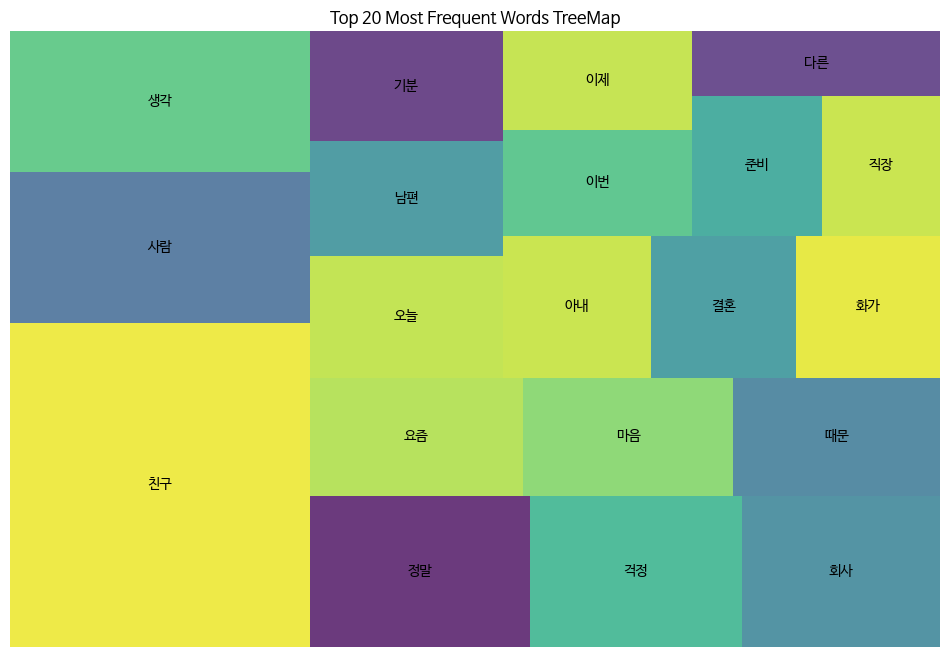

In [ ]:
most_common_words = word_count.most_common(top_n)

words = [word[0] for word in most_common_words]
sizes = [word[1] for word in most_common_words]

plt.figure(figsize=(12, 8))
squarify.plot(sizes=sizes, label=words, alpha=0.8)
plt.axis('off')
plt.title(f'Top {top_n} Most Frequent Words TreeMap')
plt.show()

##### 워드클라우드

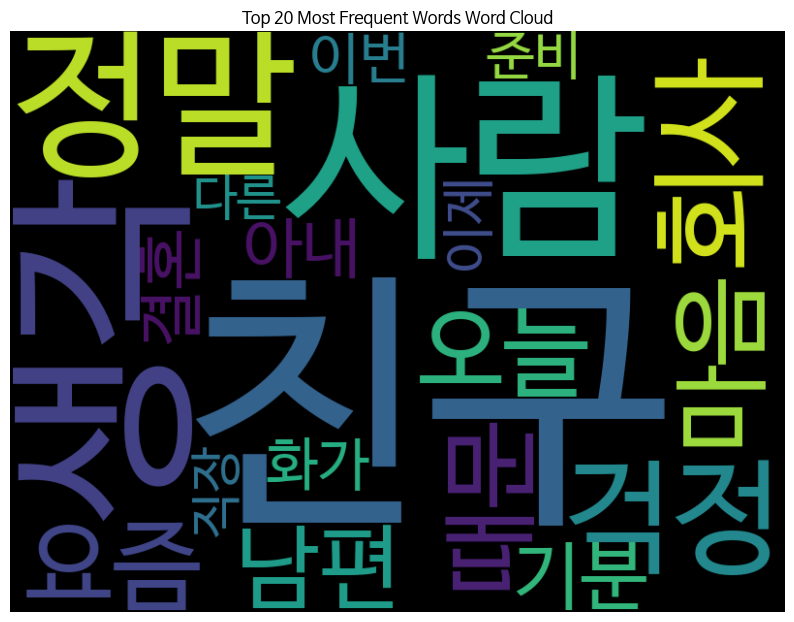

In [ ]:
top_n = 20
most_common_words = word_count.most_common(top_n)
word_freq = {word[0]: word[1] for word in most_common_words}

wc = WordCloud(font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf',
               background_color='black',
               width=800, height=600)
wc.generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')  # 축을 보이지 않게 설정
plt.title(f'Top {top_n} Most Frequent Words Word Cloud')
plt.show()


##### 연령대별 우울 감정 빈도

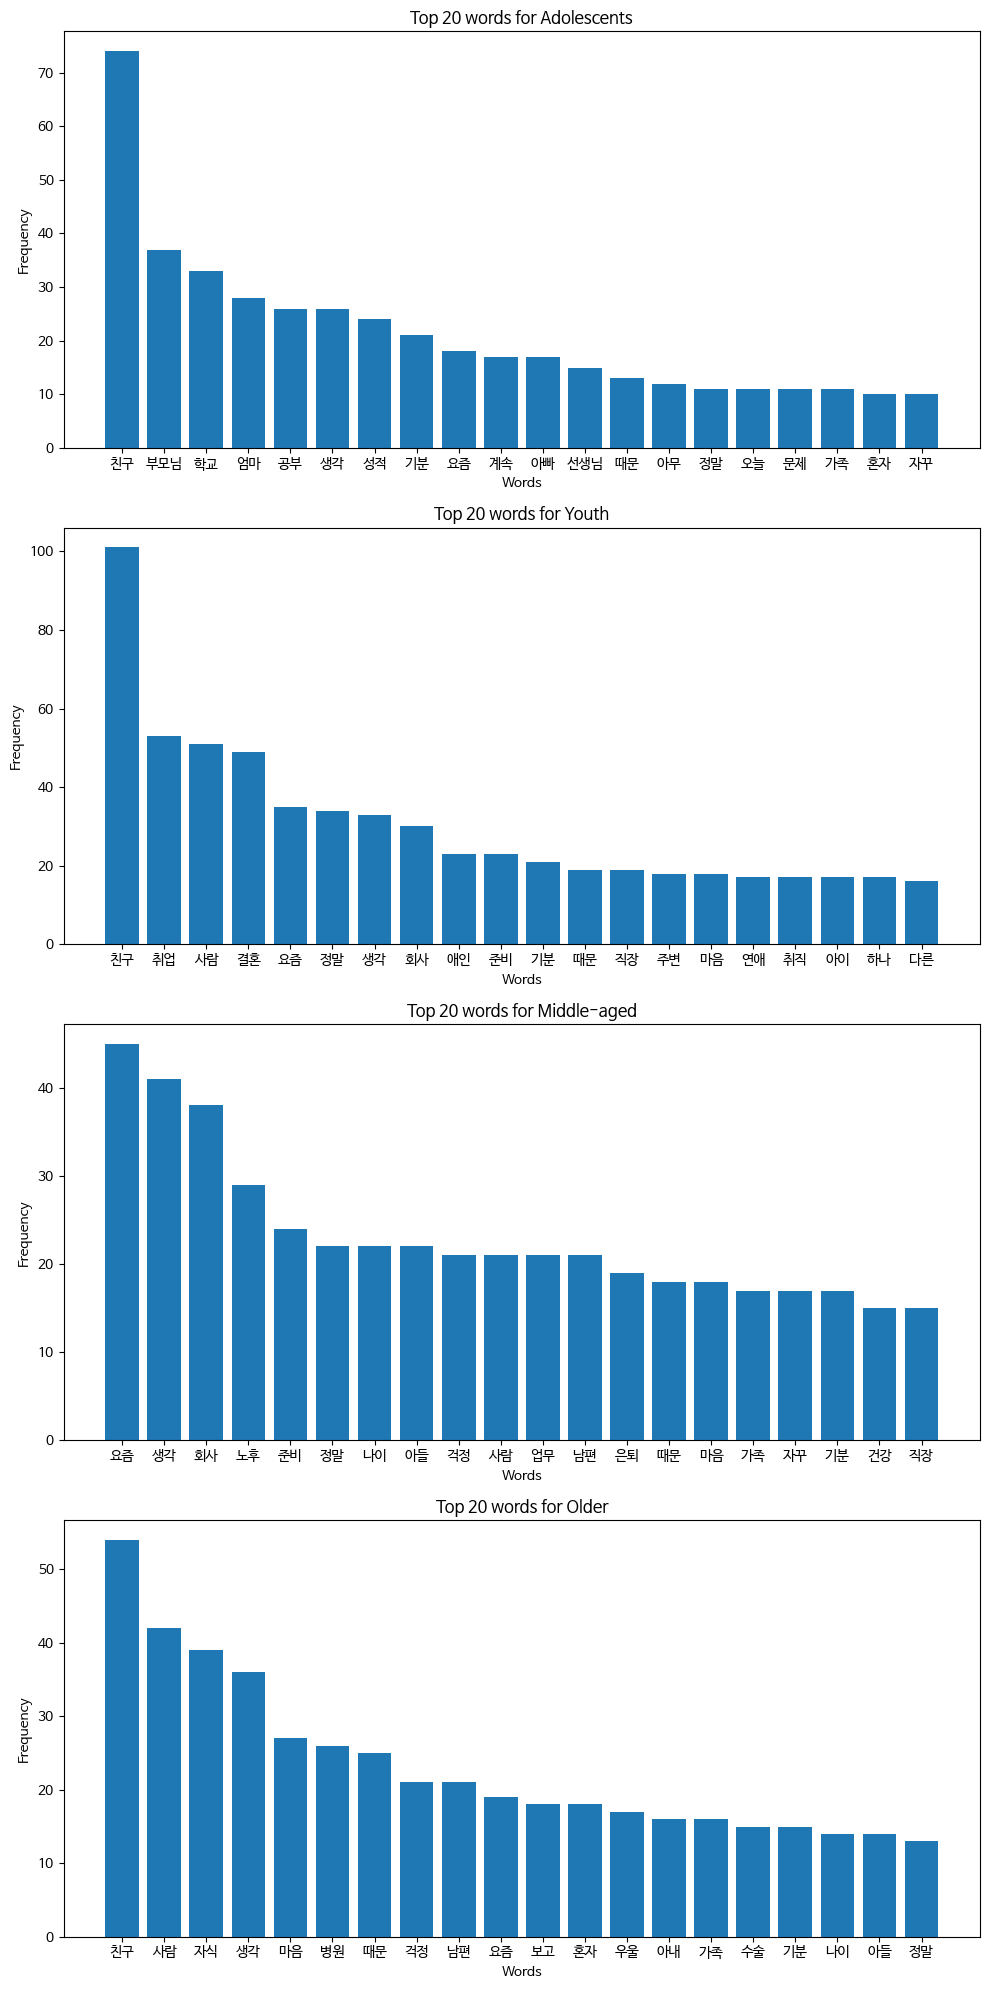

In [ ]:
age_groups = ['청소년', '청년', '중년', '노년']
age_group_names = ['Adolescents', 'Youth', 'Middle-aged', 'Older']
top_n = 20


age_group_word_freqs = {}

for age, name in zip(age_groups, age_group_names):
    filtered_df = df[(df['연령'] == age) & (df['감정_소분류'] == '우울한')]

    corpus = " ".join(filtered_df['사람문장'].tolist())

    cleaned_words = text_cleaning(corpus)
    word_counter = Counter(cleaned_words)

    age_group_word_freqs[name] = word_counter.most_common(top_n)

fig, axes = plt.subplots(len(age_groups), 1, figsize=(10, 20))

for ax, (name, common_words) in zip(axes, age_group_word_freqs.items()):
    words = [word[0] for word in common_words]
    counts = [word[1] for word in common_words]
    ax.bar(words, counts)
    ax.set_title(f'Top {top_n} words for {name}')
    ax.set_ylabel('Frequency')
    ax.set_xlabel('Words')

plt.tight_layout()
plt.show()
